In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
#from yellowbrick.cluster import KElbowVisualizer

# 1. Read data

In [17]:
df = pd.read_csv("output.csv", sep=",")
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Childhome,FamilyMembers,AverageIncome,Age,NumTotalPurchase
0,5524,1957,1,Single,58138.0,0,0,2012-04-09,58,635,...,0,0,3,11,1,0,1,58138.000000,55,22
1,2174,1954,1,Single,46344.0,1,1,2014-08-03,38,11,...,0,0,3,11,0,2,3,15448.000000,60,4
2,4141,1965,1,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,3,11,0,0,2,71613.000000,48,20
3,6182,1984,1,Together,26646.0,1,0,2014-10-02,26,11,...,0,0,3,11,0,1,3,17764.000000,30,6
4,5324,1981,3,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,3,11,0,1,3,38862.000000,33,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2214,10870,1967,1,Married,61223.0,0,1,2013-06-13,46,709,...,0,0,3,11,0,1,3,40815.333333,46,16
2215,4001,1946,3,Together,64014.0,2,1,2014-10-06,56,406,...,0,0,3,11,0,3,5,25605.600000,68,15
2216,7270,1981,1,Divorced,56981.0,0,0,2014-01-25,91,908,...,0,0,3,11,0,0,1,56981.000000,33,18
2217,8235,1956,2,Together,69245.0,0,1,2014-01-24,8,428,...,0,0,3,11,0,1,3,46163.333333,58,21


# 2. Feature Engineering

In [18]:
# create features related to Promotion behavior
df['DiscountPurchaseRate'] = df['NumDealsPurchases'] / df['NumTotalPurchase']
df['PromoSpending'] = (df['NumDealsPurchases'] / df['NumTotalPurchase']) * df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)


# clean the new columns
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['DiscountPurchaseRate'].fillna(0, inplace=True)
df['PromoSpending'].fillna(0, inplace=True)

# check the new features
df[['DiscountPurchaseRate', 'NumTotalPurchase', 'PromoSpending']].describe()

/var/folders/91/5md42ts97634kl9z05d_nbyc0000gn/T/ipykernel_36364/4277542976.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['DiscountPurchaseRate'].fillna(0, inplace=True)
/var/folders/91/5md42ts97634kl9z05d_nbyc0000gn/T/ipykernel_36364/4277542976.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

,DiscountPurchaseRate,NumTotalPurchase,PromoSpending
count,2219.000000,2219.000000,2219.000000
mean,0.241128,12.517350,80.998694
std,0.172000,7.160912,92.894452
min,0.000000,0.000000,0.000000
25%,0.083333,6.000000,21.071429
50%,0.200000,12.000000,58.173913
75%,0.333333,18.000000,105.302521
max,1.000000,32.000000,1015.625000


In [19]:
# one-hot encoding to Marital_Status
df = pd.get_dummies(df, columns=['Marital_Status'])

In [20]:
# convert object to datetime
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"],format='mixed')

# 3. Dimension Reduction and Clustering

In [21]:
# scale and fit for clustering
scaler = StandardScaler()
scaled_features_promo = scaler.fit_transform(df[['DiscountPurchaseRate', 'NumTotalPurchase', 'PromoSpending']])
scaled_features_promo

array([[-0.60923142,  1.32452217,  1.50205686],
       [ 1.50540488, -1.18969058, -0.72678085],
       [-1.11145754,  1.0451652 , -0.45436735],
       ...,
       [-1.0791506 ,  0.76580823, -0.12979211],
       [-0.84838671,  1.18484369, -0.00767689],
       [ 0.77849865, -0.63097663, -0.17764692]])

In [7]:
# Dimension Reduction: PCA
pca = PCA(n_components=3)
pca.fit(scaled_features_promo)
df_PCA = pd.DataFrame(pca.transform(scaled_features_promo), columns=(['DiscountPurchaseRate', 'NumTotalPurchase', 'PromoSpending']))
df_PCA.describe().T

,count,mean,std,min,25%,50%,75%,max
DiscountPurchaseRate,2219.0,8.805735e-18,1.291560,-3.038827,-1.186972,-0.041970,1.194059,3.827493
NumTotalPurchase,2219.0,2.081355e-17,1.066328,-1.632386,-0.669920,-0.356166,0.375771,10.098953
PromoSpending,2219.0,-1.120730e-17,0.442910,-1.609339,-0.299281,-0.024358,0.284086,3.090704


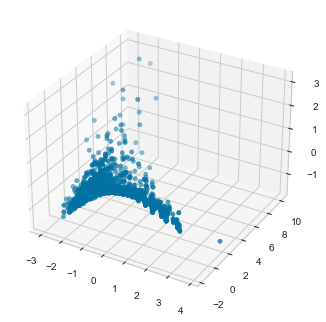

In [22]:
# 3D Projection Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_PCA["DiscountPurchaseRate"],df_PCA["NumTotalPurchase"],df_PCA["PromoSpending"])
plt.show()

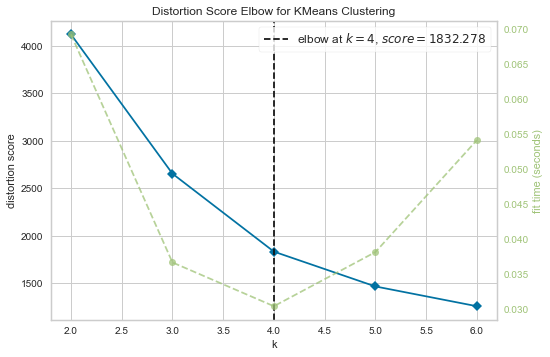

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# Clustering: Find the best number of clusters
#KElbowVisualizer(KMeans(),k=6).fit(df_PCA).show()
#Not working in linux virtual environment but when tested on mac, it gave the optimum number of clusters (=4)

In [24]:
# Clustering: Use KMeans to cluster customers
kmeans_promo = KMeans(n_clusters=4, random_state=10)
df_PCA['PromoCluster'] = kmeans_promo.fit_predict(scaled_features_promo)

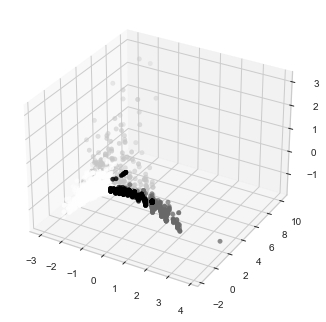

In [26]:
# plot the clusters
plt.figure()
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(df_PCA["DiscountPurchaseRate"],df_PCA["NumTotalPurchase"],df_PCA["PromoSpending"],c=df_PCA["PromoCluster"])
plt.show()

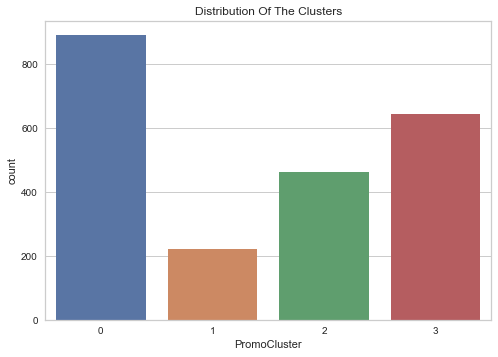

In [27]:
# Plotting countplot of clusters
pl = sns.countplot(x=df_PCA["PromoCluster"],palette="deep")
pl.set_title("Distribution Of The Clusters")
plt.show()

# 4. Features Discovery

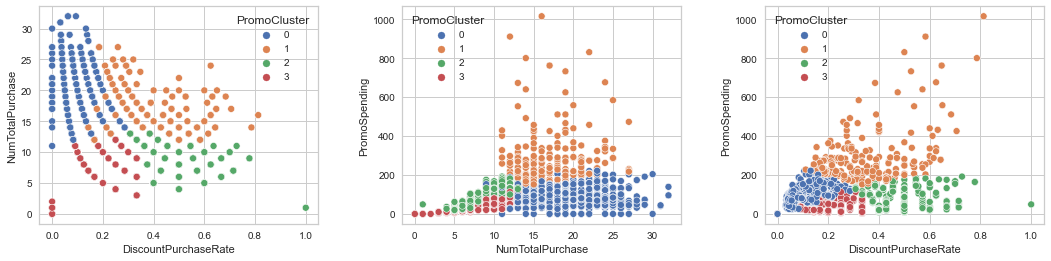

In [28]:
# 2D version of clusters
_, ax = plt.subplots(ncols=3, figsize=(18, 4))
sns.scatterplot(data=df_PCA, x=df["DiscountPurchaseRate"], y=df["NumTotalPurchase"], hue=df_PCA["PromoCluster"], ax=ax[0],palette="deep") 
sns.scatterplot(data=df_PCA, x=df["NumTotalPurchase"], y=df["PromoSpending"], hue=df_PCA["PromoCluster"], ax=ax[1],palette="deep") 
sns.scatterplot(data=df_PCA, x=df["DiscountPurchaseRate"], y=df["PromoSpending"], hue=df_PCA["PromoCluster"], ax=ax[2],palette="deep")
plt.subplots_adjust(wspace=0.3)
plt.show()

- Cluster 0: Frequent purchasers, low discount usage, low promotional influence.
- Cluster 1: Moderate purchasers, moderate discount usage, high promo spending.
- Cluster 2: Few purchases, wide range of discount usage, low promotional engagement.
- Cluster 3: Few purchases, low discount usage, but high variability in promo spending.

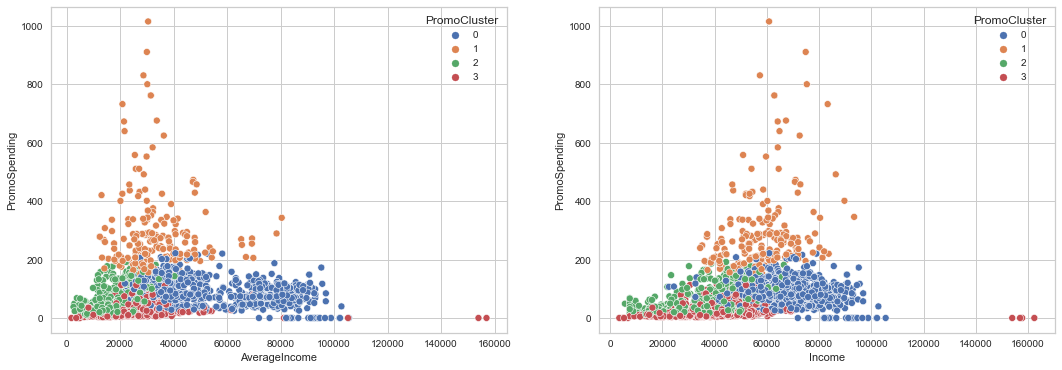

In [29]:
# Income vs PromoSpending
_, ax = plt.subplots(ncols=2, figsize=(18, 6))
sns.scatterplot(data = df_PCA,x=df["AverageIncome"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.scatterplot(data = df_PCA,x=df["Income"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
plt.show()

- Cluster 0: Higher-income customers, seldom engage in promotional spending.
- Cluster 1: Middle-to-lower-income customers, highly engaged in promotional spending, particularly those earning 10,000–60,000.
- Cluster 2: Lower-income customers, conservative promo spending habits, generally under 200.
- Cluster 3: High-income earners, highly variable promo spending behavior, ranging from minimal to extensive spending.

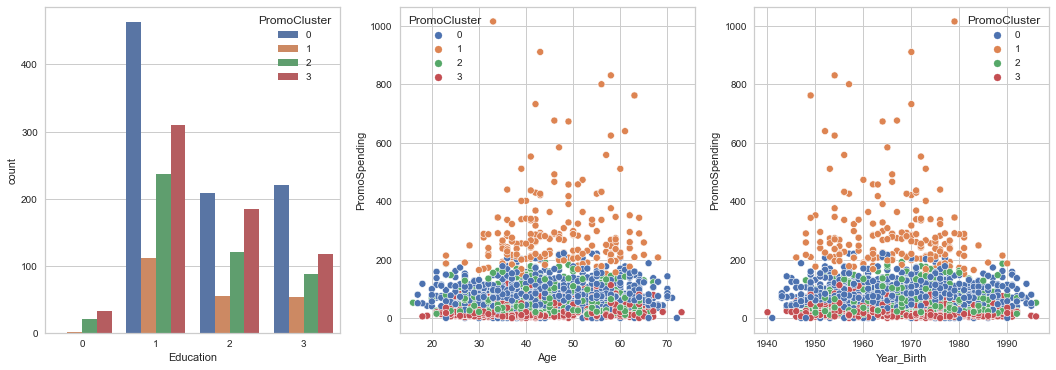

Age mean: [45.90796857463524, 46.5, 42.609913793103445, 42.0916149068323]


In [77]:
# Education and Age
_, ax = plt.subplots(ncols=3, figsize=(18, 6))
sns.countplot(x=df["Education"], hue="PromoCluster",data = df_PCA,ax=ax[0],palette="deep")
sns.scatterplot(data = df_PCA,x=df["Age"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
sns.scatterplot(data = df_PCA,x=df["Year_Birth"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[2],palette="deep")
plt.show()
print(f'Age mean: {[df[df_PCA["PromoCluster"]==n]["Age"].mean() for n in range(0,4)]}')

- Cluster 0 (Blue): Primarily middle- to higher-education individuals with low promo spending, regardless of age or birth year.
- Cluster 1 (Orange): A highly promotion-driven group with varied education levels, particularly responsive to promotions, leading to high promo spending (up to 1000).
- Cluster 2 (Green): A mixed-education cluster that tends to have low promo spending, irrespective of age or birth year.
- Cluster 3 (Red): A smaller, mixed-education group with variable but occasionally high promo spending, showing outliers with significant engagement in promotions.

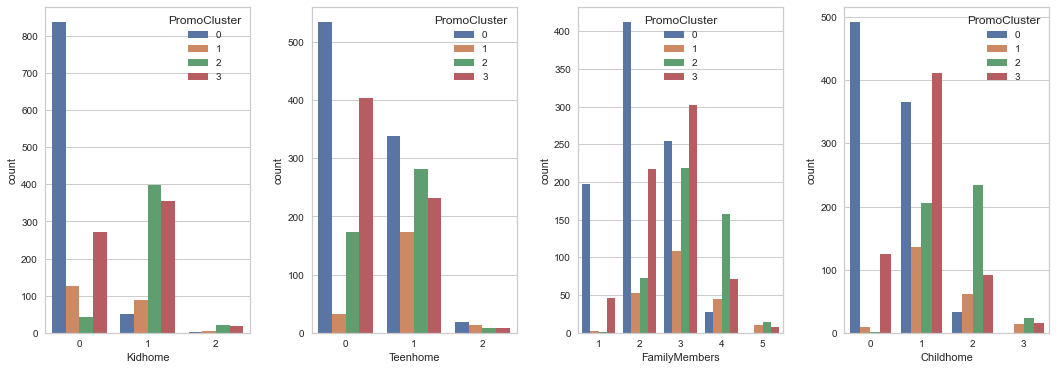

In [40]:
# Family members
_, ax = plt.subplots(ncols=4, figsize=(18, 6))
sns.countplot(data = df_PCA,x=df["Kidhome"],hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.countplot(data = df_PCA,x=df["Teenhome"], hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
sns.countplot(data = df_PCA,x=df["FamilyMembers"], hue=df_PCA["PromoCluster"],ax=ax[2],palette="deep")
sns.countplot(data = df_PCA,x=df["Childhome"],hue=df_PCA["PromoCluster"],ax=ax[3],palette="deep")
plt.subplots_adjust(wspace=0.3)
plt.show()

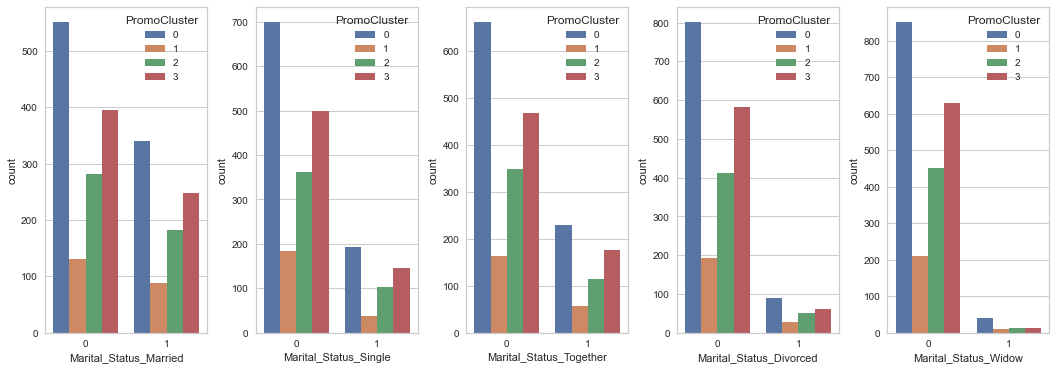

In [70]:
# Marital Status
_, ax = plt.subplots(ncols=5, figsize=(18, 6))
sns.countplot(data = df_PCA,x=df["Marital_Status_Married"]*1,hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.countplot(data = df_PCA,x=df["Marital_Status_Single"]*1, hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
sns.countplot(data = df_PCA,x=df["Marital_Status_Together"]*1, hue=df_PCA["PromoCluster"],ax=ax[2],palette="deep")
sns.countplot(data = df_PCA,x=df["Marital_Status_Divorced"]*1,hue=df_PCA["PromoCluster"],ax=ax[3],palette="deep")
sns.countplot(data = df_PCA,x=df["Marital_Status_Widow"]*1,hue=df_PCA["PromoCluster"],ax=ax[4],palette="deep")
plt.subplots_adjust(wspace=0.3)
plt.show()

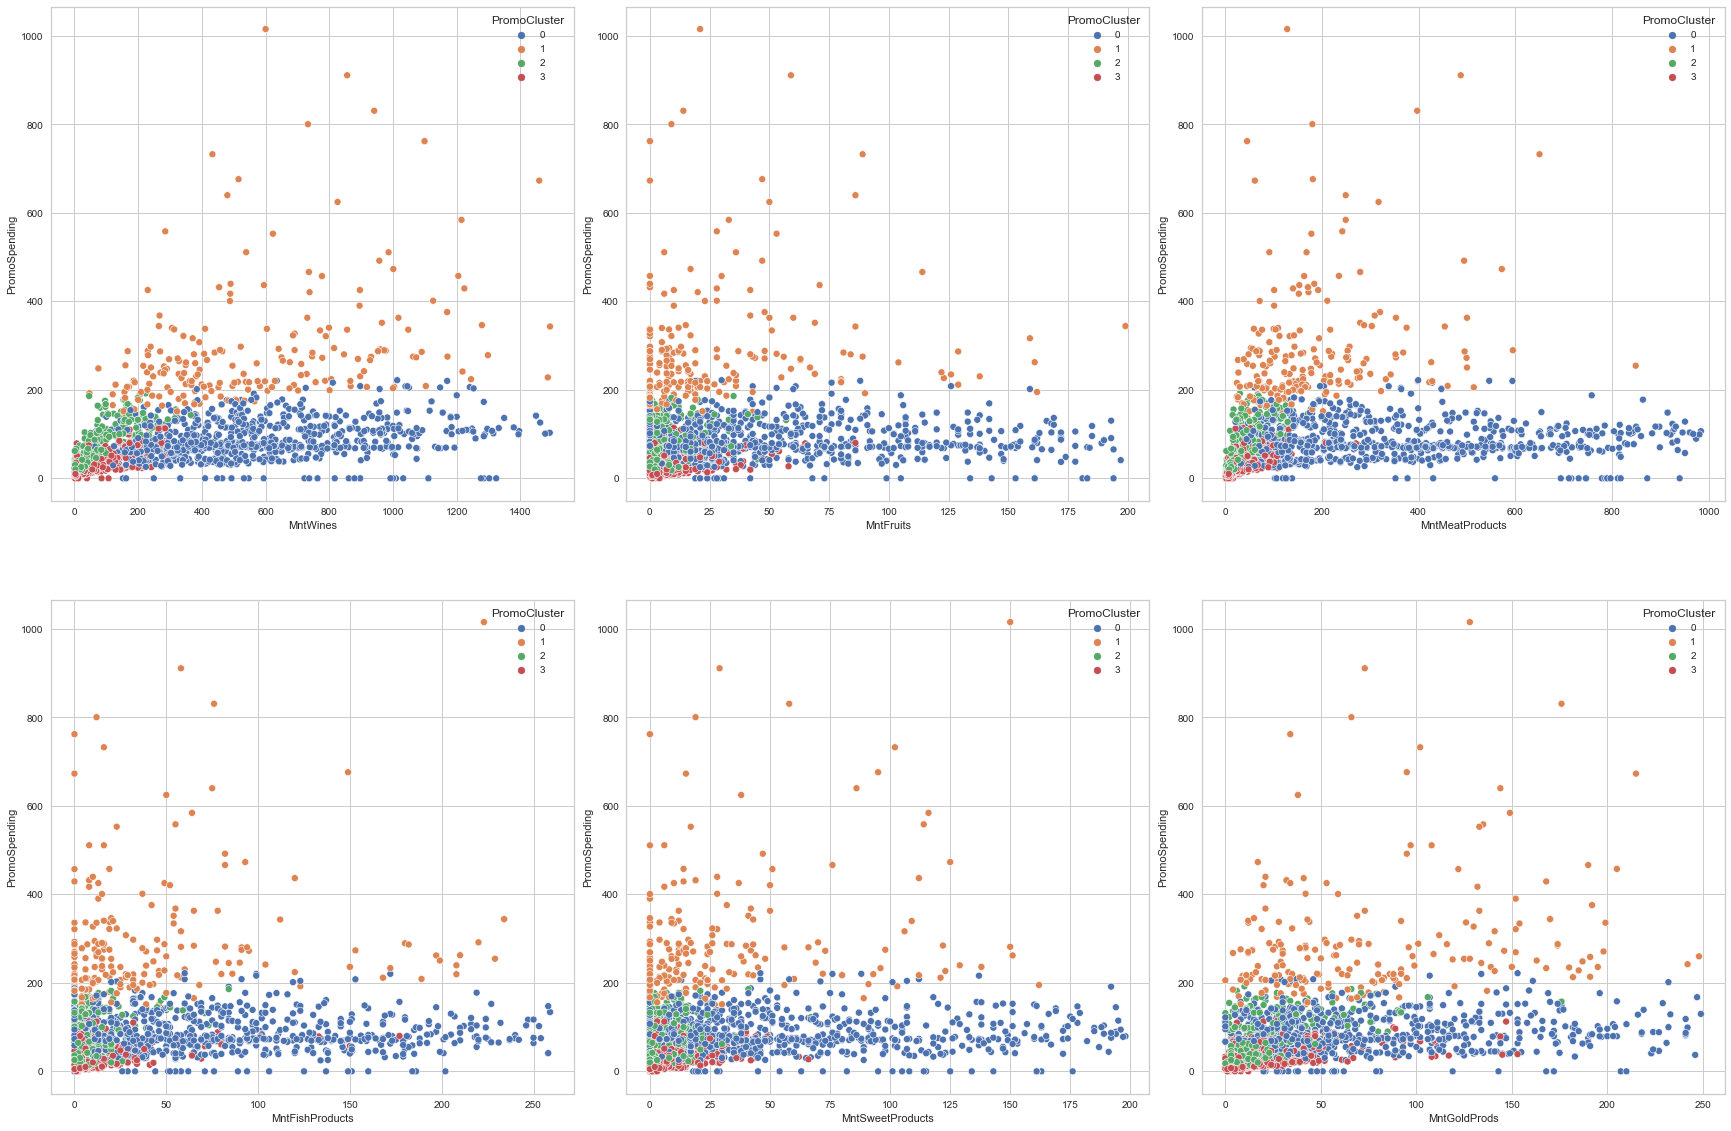

In [51]:
# NumProductPurchases
_, ax = plt.subplots(nrows=2,ncols=3,figsize=(30, 20))
sns.scatterplot(data = df_PCA,x=df["MntWines"],y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[0][0],palette="deep")
sns.scatterplot(data = df_PCA,x=df["MntFruits"],y=df["PromoSpending"], hue=df_PCA["PromoCluster"],ax=ax[0][1],palette="deep")
sns.scatterplot(data = df_PCA,x=df["MntMeatProducts"],y=df["PromoSpending"], hue=df_PCA["PromoCluster"],ax=ax[0][2],palette="deep")
sns.scatterplot(data = df_PCA,x=df["MntFishProducts"],y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[1][0],palette="deep")
sns.scatterplot(data = df_PCA,x=df["MntSweetProducts"],y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[1][1],palette="deep")
sns.scatterplot(data = df_PCA,x=df["MntGoldProds"],y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[1][2],palette="deep")
plt.subplots_adjust(wspace=0.1)
plt.show()

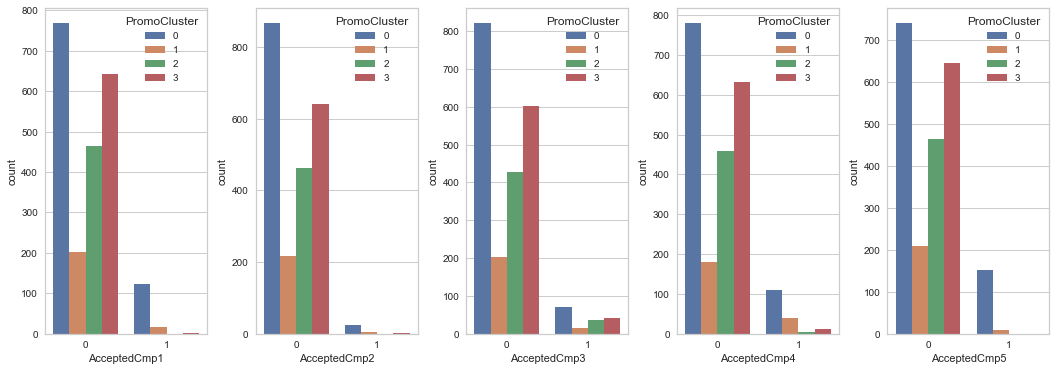

In [55]:
# AcceptedCmp
_, ax = plt.subplots(ncols=5, figsize=(18, 6))
sns.countplot(data = df_PCA,x=df["AcceptedCmp1"],hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.countplot(data = df_PCA,x=df["AcceptedCmp2"], hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
sns.countplot(data = df_PCA,x=df["AcceptedCmp3"], hue=df_PCA["PromoCluster"],ax=ax[2],palette="deep")
sns.countplot(data = df_PCA,x=df["AcceptedCmp4"],hue=df_PCA["PromoCluster"],ax=ax[3],palette="deep")
sns.countplot(data = df_PCA,x=df["AcceptedCmp5"],hue=df_PCA["PromoCluster"],ax=ax[4],palette="deep")
plt.subplots_adjust(wspace=0.3)
plt.show()

<AxesSubplot:xlabel='NumStorePurchases', ylabel='PromoSpending'>

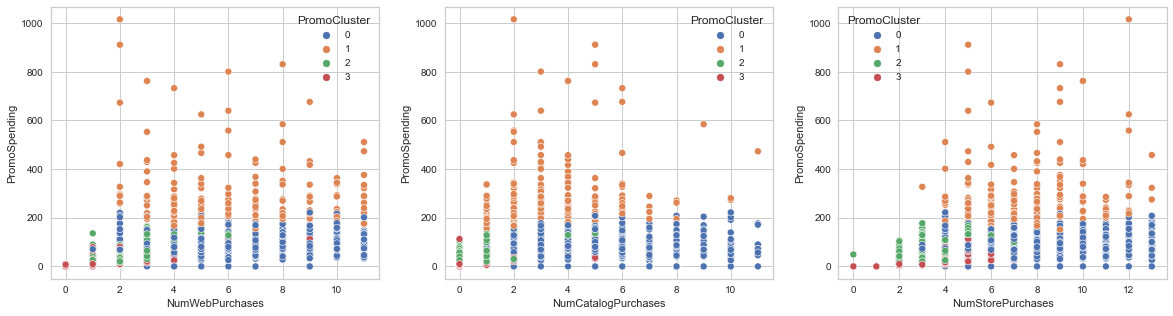

In [60]:
# NumPurchases: Ways
_, ax = plt.subplots(ncols=3,figsize=(20, 5))
sns.scatterplot(data = df_PCA,x=df["NumWebPurchases"],y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.scatterplot(data = df_PCA,x=df["NumCatalogPurchases"],y=df["PromoSpending"], hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
sns.scatterplot(data = df_PCA,x=df["NumStorePurchases"],y=df["PromoSpending"], hue=df_PCA["PromoCluster"],ax=ax[2],palette="deep")

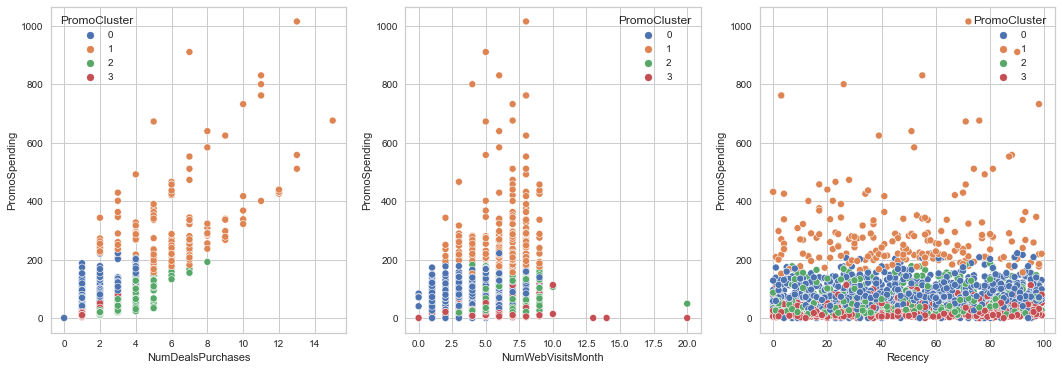

In [66]:
# Other features
_, ax = plt.subplots(ncols=3, figsize=(18, 6))
sns.scatterplot(data = df_PCA,x=df["NumDealsPurchases"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.scatterplot(data = df_PCA,x=df["NumWebVisitsMonth"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
sns.scatterplot(data = df_PCA,x=df["Recency"], y=df["PromoSpending"],hue=df_PCA["PromoCluster"],ax=ax[2],palette="deep")
plt.show()

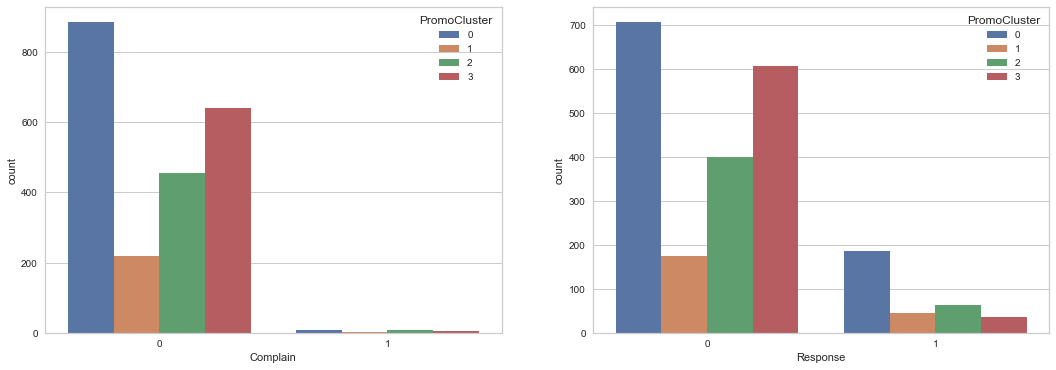

In [67]:
# Response
_, ax = plt.subplots(ncols=2, figsize=(18, 6))
sns.countplot(data = df_PCA,x=df["Complain"],hue=df_PCA["PromoCluster"],ax=ax[0],palette="deep")
sns.countplot(data = df_PCA,x=df["Response"], hue=df_PCA["PromoCluster"],ax=ax[1],palette="deep")
plt.show()

# 5. Conclusion
### Cluster 0:
